In [1]:
!pip install sounddevice
!apt install libportaudio2
!pip install spafe
!pip install pydub

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 65.3 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Fetched 65.3 kB in 1s (105 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 120899 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.1_amd64.deb ...
Unpacking libportaudio2:amd64 (19.6.0-1.1) ...
Setting up libportaudio2:amd64 (19.6.0-1.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/lib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
import librosa
from spafe.features.gfcc import gfcc

In [19]:


samplerate_one, one = wavfile.read('piano1.wav')
samplerate_two, two = wavfile.read('A-short-scary-bass.wav')

print('Sampling Rate #1 and #2:', samplerate_one, samplerate_two)
print('Audio Shape #1 and #2:', np.shape(one), np.shape(two))



Sampling Rate #1 and #2: 22050 44100
Audio Shape #1 and #2: (95872,) (456365,)


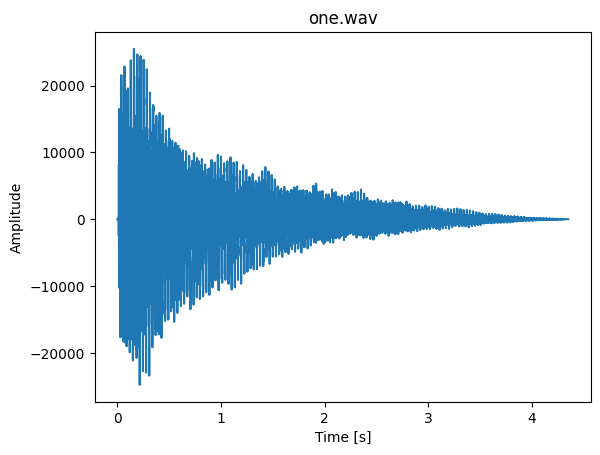

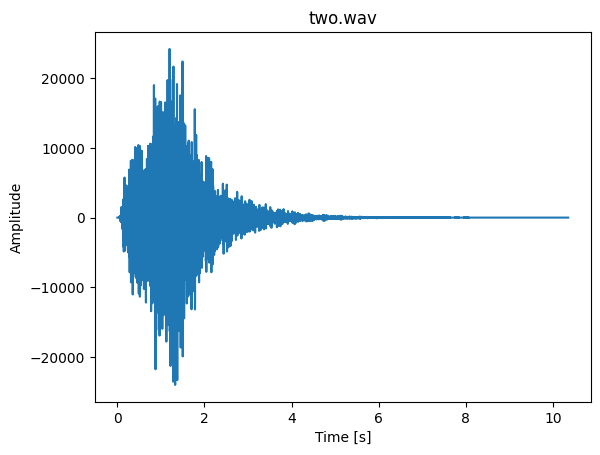

In [20]:


duration = len(one) / samplerate_one
time = np.arange(0, duration, 1 / samplerate_one)

plt.plot(time, one)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('one.wav')
plt.show()

duration = len(two) / samplerate_two
time = np.arange(0, duration, 1 / samplerate_two)

plt.plot(time, two)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('two.wav')
plt.show()



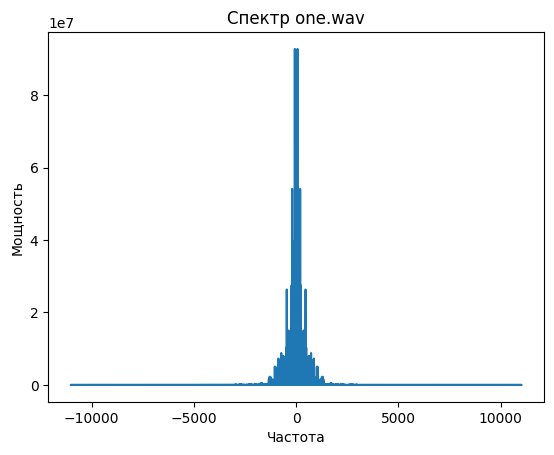

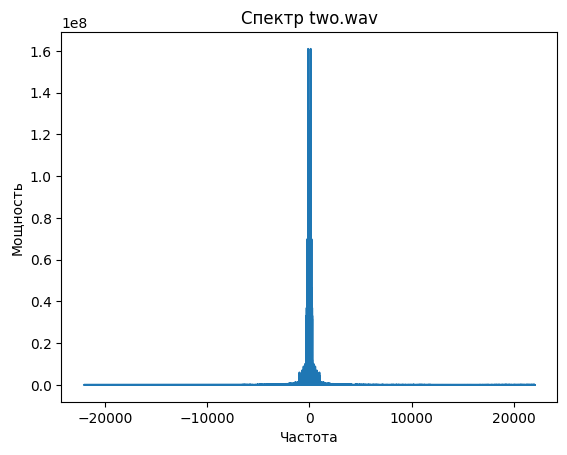

In [21]:


from scipy.fft import fft, fftfreq

duration = len(one) / samplerate_one
N = int(samplerate_one * duration)
yf = fft(one)
xf = fftfreq(N, 1 / samplerate_one)
plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.title('Спектр one.wav')
plt.show()

duration = len(two) / samplerate_two
N = int(samplerate_two * duration)
yf = fft(two)
xf = fftfreq(N, 1 / samplerate_two)
plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.title('Спектр two.wav')
plt.show()




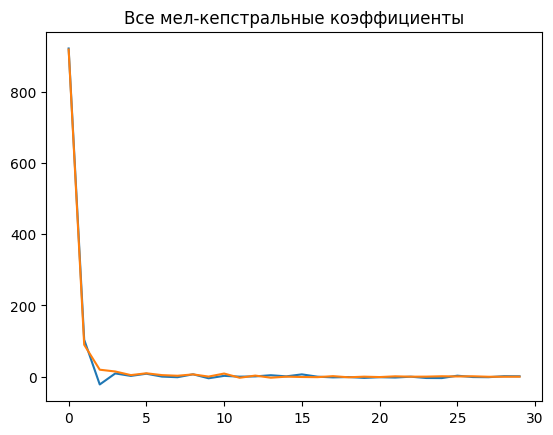

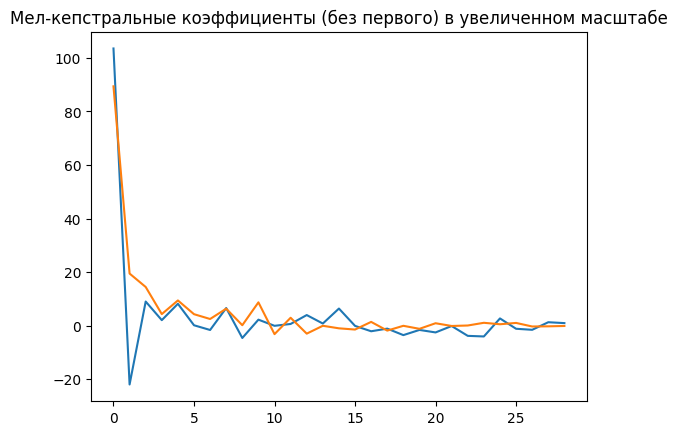

In [22]:
import scipy.fft

def B_inv(b):
    return 700 * (np.exp(b / 1125) - 1)

def B(b):
    return 1125 * np.log(1 + b / 700)

def get_filter_points(fmin, fmax, mel_filter_num, wav_size, sample_rate=44100):
    mels = np.linspace(B(fmin), B(fmax), num=mel_filter_num + 2)
    freqs = B_inv(mels)

    return np.floor((wav_size + 1) / sample_rate * freqs).astype(int)

def H(k, m, f):
    if k >= f[m - 1] and k < f[m]:
        return (k - f[m - 1]) / (f[m] - f[m - 1])
    if k >= f[m] and k <= f[m + 1]:
        return (f[m + 1] - k) / (f[m + 1] - f[m])
    return 0

mfccs = []
datas = [one, two]
rates = [samplerate_one, samplerate_two]

for i in range(len(datas)):
    x = datas[i]
    X = scipy.fft.fft(datas[i])
    M = 30
    N = len(X)

    filters_points = get_filter_points(0, rates[i] / 2, M, N)

    S = []

    for m in range(1, M + 1):
        Si = 0
        for k in range(N - 1):
            Si += (np.abs(X[k]) ** 2) * H(k, m, filters_points)
        S += [np.log(Si)]

    c = []

    for n in range(M):
        ci = 0
        for m in range(M):
            ci += S[m] * np.cos(np.pi * n * (m + 0.5) / M)
        c += [ci]
    mfccs += [c]

for mfcc in mfccs:
    plt.plot(mfcc)
plt.title('Все мел-кепстральные коэффициенты')
plt.show()

for mfcc in mfccs:
    plt.plot(mfcc[1:])
plt.title('Мел-кепстральные коэффициенты (без первого) в увеличенном масштабе')
plt.show()

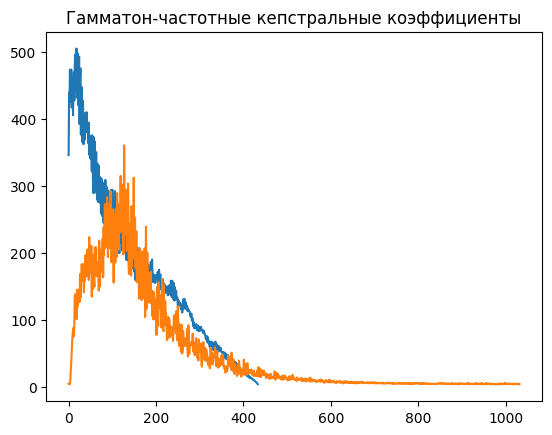

In [23]:


from spafe.features.gfcc import gfcc

for i in range(len(datas)):
    gfccs = gfcc(datas[i], fs=rates[i], num_ceps=1)
    plt.plot(gfccs)
plt.title('Гамматон-частотные кепстральные коэффициенты')
plt.show()



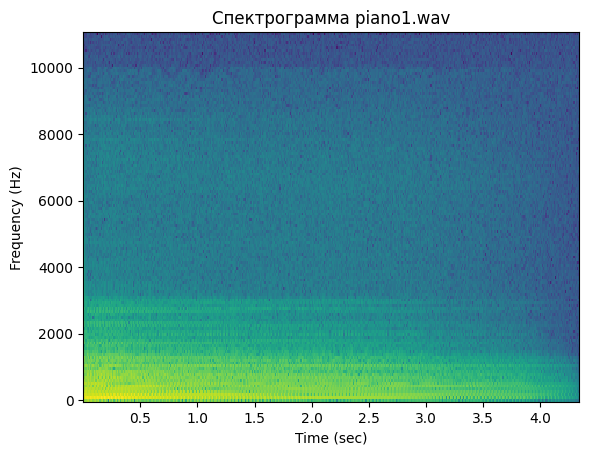

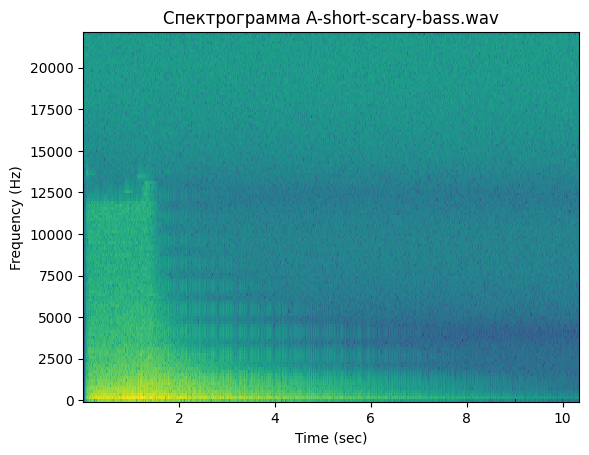

In [24]:
names = ['piano1.wav', 'A-short-scary-bass.wav']
for i in range(len(datas)):
    s = rates[i]

    fr, tm, spgram = signal.spectrogram(datas[i],s)
    lspg = np.log(spgram)

    plt.pcolormesh(tm,fr,lspg,shading='auto')
    plt.title(f'Спектрограмма {names[i]}')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.show()

